In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

In [2]:
%%time
df_2018 = pd.read_excel('Vigitel-2018-peso-rake.xls')
df_2017 = pd.read_excel('Vigitel-2017-peso-rake.xls')
df_2016 = pd.read_excel('Vigitel-2016-peso-rake.xls')
df_2015 = pd.read_excel('Vigitel-2015-peso-rake.xls')
df_2014 = pd.read_excel('Vigitel-2014-peso-rake.xls')
df_2013 = pd.read_excel('Vigitel-2013-peso-rake.xls')
df_2012 = pd.read_excel('Vigitel-2012-peso-rake.xls')
df_2011 = pd.read_excel('Vigitel-2011-peso-rake.xls')
df_2010 = pd.read_excel('Vigitel-2010-peso-rake.xls')
df_2009 = pd.read_excel('Vigitel-2009-peso-rake.xls')
df_2008 = pd.read_excel('Vigitel-2008-peso-rake.xls')
df_2007 = pd.read_excel('Vigitel-2007-peso-rake.xls')
df_2006 = pd.read_excel('Vigitel-2006-peso-rake.xls')

CPU times: user 24min 20s, sys: 39.6 s, total: 24min 59s
Wall time: 31min 26s


In [3]:
dfs = df_2018.append([df_2017,df_2016,df_2015,df_2014,df_2013,df_2012,df_2011,df_2010,df_2009,df_2008,df_2007,df_2006],ignore_index=True)
dfs = df_2018

In [4]:
dfs2 = dfs[['diab','ano','cidade','q6','q7','civil','q8a','q9','q11','q29','hart','r202','hortareg','frutareg','q42','fumante']]

In [5]:
dfs2 = dfs2.rename(columns={'q6':'idade','q7':'sexo','q9':'peso', 'q11':'altura','q8a':'escolaridade','q29':'refrigerante','r202':'idade_diab','q42':'exercicio'})

In [6]:
dfs2['civil'] = dfs2.civil.replace({888:0,3:2,4:3,5:3})
dfs2['escolaridade'] = dfs2.escolaridade.replace({2:1,3:1,4:2,5:3,6:4,7:5,8:1})
dfs2['refrigerante'] = dfs2.refrigerante.replace({3:2,4:3,5:4,6:4})
dfs2['exercicio'] = dfs2.exercicio.replace({2:0})
dfs2.drop(dfs2.loc[dfs2['peso']==777].index, inplace=True)
dfs2.drop(dfs2.loc[dfs2['peso']==888].index, inplace=True)
dfs2.drop(dfs2.loc[dfs2['altura']==777].index, inplace=True)
dfs2.drop(dfs2.loc[dfs2['altura']==888].index, inplace=True)
dfs2.drop(dfs2.loc[dfs2['escolaridade']==777].index, inplace=True)
dfs2.drop(dfs2.loc[dfs2['escolaridade']==888].index, inplace=True)
dfs2.drop(dfs2.loc[dfs2['idade_diab']==777].index, inplace=True)

In [7]:
dfs2['delta_idade_diab'] = dfs2['idade']-dfs2['idade_diab']
dfs2['idade_diab2'] = dfs2['idade_diab']
dfs2['idade_diab2'][dfs2.delta_idade_diab > 5] = 0
dfs2['idade_diab2'][dfs2.delta_idade_diab <= 5] = 1
dfs2['idade_diab2'].fillna(0, inplace = True)

In [8]:
dfs2['diab'].value_counts() / len(dfs2) * 100

0    90.209073
1     9.790927
Name: diab, dtype: float64

In [9]:
dfs2['idade_diab2'].value_counts() / len(dfs2) * 100

0.0    96.645859
1.0     3.354141
Name: idade_diab2, dtype: float64

In [10]:
dfs2['altura'].fillna(dfs2['altura'].mean(), inplace = True)
dfs2['peso'].fillna(dfs2['peso'].mean(), inplace = True)
dfs2['escolaridade'].fillna(dfs2['escolaridade'].mean(), inplace = True)

In [11]:
dfs2['IMC'] = dfs2['peso'] / ((dfs2['altura']* 0.01)**2)

def class_imc(IMC):
    classification = 0
    if IMC > 30:
        classification = 4
    elif IMC > 25:
        classification = 3        
    elif IMC > 18.5:
        classification = 2
    else:
        classification = 1        
    return classification
dfs2['imc_class'] = dfs2['IMC'].apply(class_imc)

In [12]:
X = dfs2.drop(['idade_diab2','diab','idade_diab','altura','peso','cidade','ano','delta_idade_diab','idade_diab','IMC'], axis = 1)
y = dfs2.idade_diab2

In [13]:
X_resampled, y_resampled = SMOTE(n_jobs=-1).fit_resample(X, y)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print(f'Size of train set: {X_train.shape}')
print(f'Size of test set: {X_test.shape}')

Size of train set: (72334, 11)
Size of test set: (18084, 11)


In [15]:
X_resampled.shape, y_resampled.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90418, 11), (90418,), (72334, 11), (18084, 11), (72334,), (18084,))

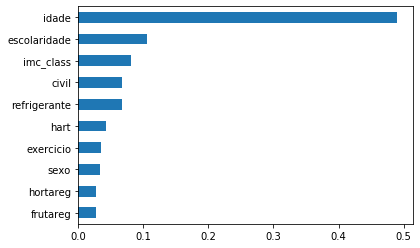

In [16]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=10,n_jobs=-1)
model.fit(X_train, y_train)
pd.Series(model.feature_importances_, index=X_resampled.columns).nlargest(10).sort_values().plot.barh();

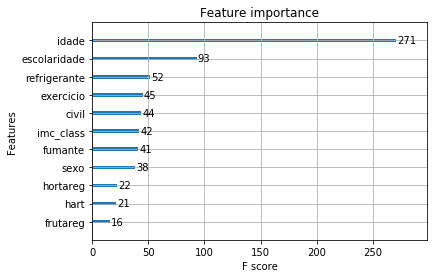

CPU times: user 49.3 s, sys: 472 ms, total: 49.8 s
Wall time: 14.2 s


In [17]:
%%time
import xgboost as xgb
from xgboost import plot_importance
model = xgb.XGBClassifier(n_jobs=-1)
model.fit(X_train, y_train)
plot_importance(model)
plt.show()

Accuracy: 0.942545896925459
Precision: 0.9130660573327793
Recall: 0.9775380851773602
CPU times: user 30.7 s, sys: 875 ms, total: 31.6 s
Wall time: 10 s


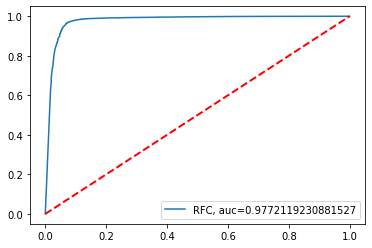

In [18]:
%%time
#clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=1, max_depth=20)
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="RFC"+", auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

In [19]:
models=['clf']

Trainning_Accuracy=[clf.score(X_train,y_train)]

Validation_Accuracy=[clf.score(X_test, y_test)]

pd.DataFrame(list(zip(Trainning_Accuracy, Validation_Accuracy)), 
                  columns =['Trainning_Accuracy', 'Validation_Accuracy'],
                  index=models)

,Trainning_Accuracy,Validation_Accuracy
clf,0.972489,0.942546


In [20]:
sklearn.metrics.r2_score(y_test, y_pred)

0.7701768384295473

In [21]:
import pickle

TESTE = 'V3.pkl'
with open(TESTE, 'wb') as file:
    pickle.dump(clf, file)

In [22]:
with open(TESTE, 'rb') as file:
    modelo = pickle.load(file)

In [23]:
features =  {'idade':["60"],'sexo':["1"],'civil':["2"],'escolaridade':["1"],'refrigerante':["2"],'hart':["1"],'hortareg':["1"],'frutareg':["1"],'exercicio':["1"],'fumante':["0"],'imc_class':["2"]}

In [24]:
X = pd.DataFrame(features)

In [25]:
resultado = modelo.predict_proba(X)

In [26]:
resultado

array([[0.77, 0.23]])

In [28]:
X_train.head()

,idade,sexo,civil,escolaridade,refrigerante,hart,hortareg,frutareg,exercicio,fumante,imc_class
67943,73,2,3,3,3,1,1,1,1,0,4
47811,81,2,2,1,4,1,0,1,1,0,3
72866,52,1,1,4,1,1,1,0,0,0,4
71491,72,2,3,3,3,1,1,1,1,0,4
42119,45,1,2,4,3,0,1,1,1,0,3


In [29]:
teste = np.array([[37,2,2,5,4,0,1,1,1,0,2]])